In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution
import torchvision.transforms as tr

from priors import *
from models import *
from data import *

torch.manual_seed(42)

In [27]:
# only run this cell if you use weights and biases for logging
import wandb

wandb.init(project = "BNN_VI", 
            config = {"learning_rate": 0.001,
                      "batch_size": 128,
                      "epochs": 10,
                      "hidden_size": 100,
                      "Temperature": 0.1,})


In [26]:
# Load MNIST dataset with specified transforms
# always use ToTensor() as first transform
# possible transforms: RandomRotation, RandomCrop, GaussianBlur
# avoid Normalize (already done), RandomHorizontalFlip (for MNIST), RandomVerticalFlip (for MNIST)
transform = tr.Compose([tr.ToTensor()])
augmentations = tr.Compose([tr.RandomRotation(15)])

dataset = Data("MNIST", augmentations = None)
train_data, test_data = dataset.get_data()

# Print some information about the dataset
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

# Create data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


Train data size:  60000
Test data size:  10000


tensor(5)


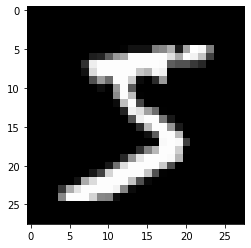

In [28]:
# display some images
image_index = 0
feature = dataset.trainset[image_index][0]
# feature = dataset.trainset_extra[image_index][0] # to display images from the augmented dataset
label = train_data[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


In [29]:
# set the Temperature
Temperature_posterior = 1

# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100], Temperature = Temperature_posterior)
print(model)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)

# train the model
epochs = 10
num_samples = 5

for epoch in tqdm.tqdm(range(epochs)):
    num_batches = len(train_loader)
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # reset loss
        loss = torch.tensor(0.0)

        # forward pass
        for e in range(num_samples):
            output, kl_divergence = model(x)
            loss += (F.nll_loss(F.softmax(output, dim = 1), y, reduction = "sum") + kl_divergence/num_batches)/num_samples

        # backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # accuracy
        acc = torch.mean(torch.argmax(F.softmax(output, dim = 1) == y).float())

        # print the loss
        if i % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}, accuracy: {acc.item()}")
            scheduler.step()
            wandb.log({"loss": loss.item(), "accuracy": acc.item(), "epoch": epoch, "batch": i})
            wandb.log({"learning_rate": scheduler.get_lr()[0]})
           
        

  0%|          | 0/10 [00:00<?, ?it/s]

Bayesian_Neural_Network(
  (layers): ModuleList(
    (0): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
    (1): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
  )
  (activation): ReLU(inplace=True)
)
Epoch: 0 | Batch: 0 | Loss: -12.32190990447998, accuracy: 0.0546875


<ipython-input-29-1128b8f25693>:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  acc = torch.mean((torch.argmax(F.softmax(output), dim = 1) == y).float())


Epoch: 0 | Batch: 100 | Loss: -8.726259231567383, accuracy: 0.0703125
Epoch: 0 | Batch: 200 | Loss: -15.34184741973877, accuracy: 0.171875
Epoch: 0 | Batch: 300 | Loss: -15.213510513305664, accuracy: 0.140625
Epoch: 0 | Batch: 400 | Loss: -11.223331451416016, accuracy: 0.0859375


 10%|█         | 1/10 [00:21<03:17, 21.95s/it]

Epoch: 1 | Batch: 0 | Loss: -15.163411140441895, accuracy: 0.1015625
Epoch: 1 | Batch: 100 | Loss: -23.074535369873047, accuracy: 0.1796875
Epoch: 1 | Batch: 200 | Loss: -25.353748321533203, accuracy: 0.1640625
Epoch: 1 | Batch: 300 | Loss: -25.195247650146484, accuracy: 0.203125
Epoch: 1 | Batch: 400 | Loss: -33.1973876953125, accuracy: 0.265625


 20%|██        | 2/10 [00:44<02:57, 22.20s/it]

Epoch: 2 | Batch: 0 | Loss: -30.978076934814453, accuracy: 0.21875
Epoch: 2 | Batch: 100 | Loss: -27.104421615600586, accuracy: 0.3046875
Epoch: 2 | Batch: 200 | Loss: -33.14254379272461, accuracy: 0.25
Epoch: 2 | Batch: 300 | Loss: -39.897308349609375, accuracy: 0.28125
Epoch: 2 | Batch: 400 | Loss: -46.80666732788086, accuracy: 0.40625


 30%|███       | 3/10 [01:07<02:37, 22.46s/it]

Epoch: 3 | Batch: 0 | Loss: -37.1356315612793, accuracy: 0.296875
Epoch: 3 | Batch: 100 | Loss: -45.813133239746094, accuracy: 0.3671875
Epoch: 3 | Batch: 200 | Loss: -46.06298828125, accuracy: 0.375
Epoch: 3 | Batch: 300 | Loss: -54.29632568359375, accuracy: 0.4609375
Epoch: 3 | Batch: 400 | Loss: -50.386112213134766, accuracy: 0.375


 40%|████      | 4/10 [01:28<02:11, 21.89s/it]

Epoch: 4 | Batch: 0 | Loss: -47.839256286621094, accuracy: 0.375
Epoch: 4 | Batch: 100 | Loss: -63.325225830078125, accuracy: 0.5
Epoch: 4 | Batch: 200 | Loss: -54.123741149902344, accuracy: 0.40625
Epoch: 4 | Batch: 300 | Loss: -59.34040069580078, accuracy: 0.4609375
Epoch: 4 | Batch: 400 | Loss: -69.49605560302734, accuracy: 0.5234375


 50%|█████     | 5/10 [01:49<01:48, 21.62s/it]

Epoch: 5 | Batch: 0 | Loss: -67.51700592041016, accuracy: 0.5
Epoch: 5 | Batch: 100 | Loss: -61.085609436035156, accuracy: 0.484375
Epoch: 5 | Batch: 200 | Loss: -74.52915954589844, accuracy: 0.5625
Epoch: 5 | Batch: 300 | Loss: -78.53136444091797, accuracy: 0.6484375
Epoch: 5 | Batch: 400 | Loss: -73.7992172241211, accuracy: 0.546875


 60%|██████    | 6/10 [02:09<01:24, 21.20s/it]

Epoch: 6 | Batch: 0 | Loss: -78.27680206298828, accuracy: 0.65625
Epoch: 6 | Batch: 100 | Loss: -76.58805847167969, accuracy: 0.5625
Epoch: 6 | Batch: 200 | Loss: -67.83426666259766, accuracy: 0.4921875
Epoch: 6 | Batch: 300 | Loss: -78.39073944091797, accuracy: 0.609375
Epoch: 6 | Batch: 400 | Loss: -79.59170532226562, accuracy: 0.6015625


 70%|███████   | 7/10 [02:30<01:03, 21.25s/it]

Epoch: 7 | Batch: 0 | Loss: -81.14752960205078, accuracy: 0.578125
Epoch: 7 | Batch: 100 | Loss: -83.19979858398438, accuracy: 0.640625
Epoch: 7 | Batch: 200 | Loss: -83.53543090820312, accuracy: 0.609375
Epoch: 7 | Batch: 300 | Loss: -86.08779907226562, accuracy: 0.7265625
Epoch: 7 | Batch: 400 | Loss: -85.84175109863281, accuracy: 0.6953125


 80%|████████  | 8/10 [02:49<00:40, 20.40s/it]

Epoch: 8 | Batch: 0 | Loss: -86.78038787841797, accuracy: 0.671875
Epoch: 8 | Batch: 100 | Loss: -90.73149108886719, accuracy: 0.6796875
Epoch: 8 | Batch: 200 | Loss: -87.52864837646484, accuracy: 0.71875
Epoch: 8 | Batch: 300 | Loss: -85.2205810546875, accuracy: 0.6875
Epoch: 8 | Batch: 400 | Loss: -88.26870727539062, accuracy: 0.75


 90%|█████████ | 9/10 [03:09<00:20, 20.27s/it]

Epoch: 9 | Batch: 0 | Loss: -94.95698547363281, accuracy: 0.7734375
Epoch: 9 | Batch: 100 | Loss: -93.6861572265625, accuracy: 0.6875
Epoch: 9 | Batch: 200 | Loss: -100.05695343017578, accuracy: 0.734375
Epoch: 9 | Batch: 300 | Loss: -90.21650695800781, accuracy: 0.703125
Epoch: 9 | Batch: 400 | Loss: -91.90170288085938, accuracy: 0.6796875


100%|██████████| 10/10 [03:31<00:00, 21.19s/it]


In [40]:
# predict class probabilities for the test data
x_test = test_data[:][0].clone().detach()
y_test = test_data[:][1].clone().detach()

predicted_probs = model.predict_probs(x_test, 100)
top_probs = torch.max(predicted_probs, axis = 1)
predicted_class = torch.argmax(predicted_probs, axis = 1)

accuracy = torch.sum(predicted_class == y_test) / len(y_test)
print(f"Accuracy: {accuracy}")

print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))

Accuracy: 0.8166000247001648
tensor([[7, 7],
        [2, 2],
        [1, 1],
        ...,
        [4, 4],
        [8, 5],
        [6, 6]])


<ipython-input-40-64b81a5d0e6c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))


In [46]:
def ece(predicted_probabilities: np.ndarray, labels: np.ndarray, n_bins: int = 30) -> float:
    """
    Computes the Expected Calibration Error (ECE).
    Many options are possible; in this implementation, we provide a simple version.
    Using a uniform binning scheme on the full range of probabilities, zero
    to one, we bin the probabilities of the predicted label only (ignoring
    all other probabilities). For the ith bin, we compute the avg predicted
    probability, p_i, and the bin's total accuracy, a_i.
    We then compute the ith calibration error of the bin, |p_i - a_i|.
    The final returned value is the weighted average of calibration errors of each bin.
    :param predicted_probabilities: Predicted probabilities, float array of shape (num_samples, num_classes)
    :param labels: True labels, int tensor of shape (num_samples,) with each entry in {0, ..., num_classes - 1}
    :param n_bins: Number of bins for histogram binning
    :return: ECE score as a float
    """
    num_samples, num_classes = predicted_probabilities.shape

    # Predictions are the classes with highest probability
    predictions = np.argmax(predicted_probabilities, axis=1)
    prediction_confidences = predicted_probabilities[range(num_samples), predictions]

    # Use uniform bins on the range of probabilities, i.e. closed interval [0.,1.]
    bin_upper_edges = np.histogram_bin_edges([], bins=n_bins, range=(0., 1.))
    bin_upper_edges = bin_upper_edges[1:]  # bin_upper_edges[0] = 0.

    probs_as_bin_num = np.digitize(prediction_confidences, bin_upper_edges)
    sums_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins, weights=prediction_confidences)
    sums_per_bin = sums_per_bin.astype(np.float32)

    total_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins) \
        + np.finfo(sums_per_bin.dtype).eps  # division by zero
    avg_prob_per_bin = sums_per_bin / total_per_bin

    onehot_labels = np.eye(num_classes)[labels]
    accuracies = onehot_labels[range(num_samples), predictions]  # accuracies[i] is 0 or 1
    accuracies_per_bin = np.bincount(probs_as_bin_num, weights=accuracies, minlength=n_bins) / total_per_bin

    prob_of_being_in_a_bin = total_per_bin / float(num_samples)

    ece_ret = np.abs(accuracies_per_bin - avg_prob_per_bin) * prob_of_being_in_a_bin
    ece_ret = np.sum(ece_ret)
    return float(ece_ret)

In [47]:
ece(predicted_probs, y_test, n_bins = 30)

0.028179404699802398

In [49]:
import torchmetrics
from torchmetrics.functional import calibration_error

calibration_error(predicted_probs, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)

tensor(0.0274)

In [24]:
wandb.finish()

accuracy,▁▁▂▂▁▂▂▂▃▃▃▃▃▄▄▅▄▅▄▅▅▅▆▇▇▆▅▆▆▇▆█▇▇▇▇█▇█▇
batch,▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
learning_rate,███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
loss,██▇██▇▇▇▆▇▆▆▆▅▅▅▅▄▅▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂
accuracy,0.67969
batch,400
epoch,9
learning_rate,0.00299
loss,-91.9017
